In [47]:
# Import Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [48]:
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
# Import Training Dataset
data = pd.read_csv('train_tweet.csv')
data.drop(columns=['id'], 
          axis = 1, 
          inplace =True)
data.head(5)

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


# Exploratory Data Analysis

In [50]:
#Kolom dataset 
print('Training Set :\n',data.columns)

Training Set :
 Index(['label', 'tweet'], dtype='object')


In [51]:
# Dimensi training dataset
data.shape

(31962, 2)

In [52]:
#Mencari kolom dan baris yang Null
print('Menjumlahkan Nilai Null dalam test set')
print(data.isnull().sum()) 

Menjumlahkan Nilai Null dalam test set
label    0
tweet    0
dtype: int64


In [53]:
# Jumlah Danger = 1 , nonDanger = 0
display(data['label'].value_counts().to_frame())
print('Perbandingan jumlah dataset = ')
print("0s : 1s  :::: ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")

,label
0,29720
1,2242


Perbandingan jumlah dataset = 
0s : 1s  ::::  13.26 : 1


data mengindikasikan unbalaced dengan ratio 13 : 1

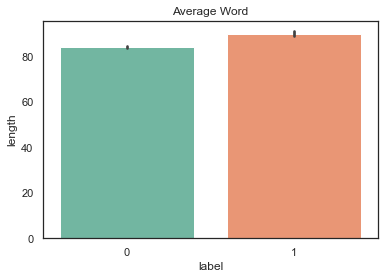

In [54]:
# Menvisualisasikan rata - rata kata 
sns.set_theme(style="white")
data['length'] = data['tweet'].apply(len)

ax2 = sns.barplot( x = 'label',
                   y = 'length',
                   data = data,
                   palette="Set2",
                   orient = "v",
                 )
                
plt.title('Average Word')
plot = ax2.get_figure()

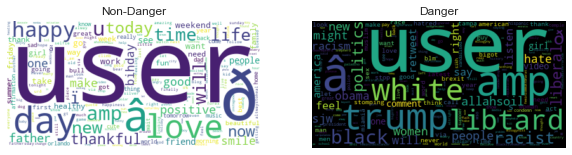

In [55]:
non_danger = " ".join(data['tweet'][data.label == 0])
danger = " ".join(data['tweet'][data.label == 1])

wordcloud_nondanger = WordCloud(collocations = False, 
                                background_color = 'white',
                                random_state= 42,
                                max_words=200,
                                margin=1).generate(non_danger)

wordcloud_danger = WordCloud(collocations = False, 
                             background_color = 'black',
                             random_state=42,
                             max_words=200,
                             margin=1).generate(danger)

fig, axs = plt.subplots(1,2 , figsize=(10,5)) #posisi kanan kiri 1-2 , ukuran 10,5

# Visualisasi untuk nondanger 
axs[0].imshow(wordcloud_nondanger, interpolation='bilinear')
axs[0].axis('off') #ngilangin garis pinggir dan angka skala
axs[0].set_title('Non-Danger')

#visualisasi untuk danger
axs[1].imshow(wordcloud_danger, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Danger')

plt.show()

In [56]:
# Menghitung distribusi dari kata
import cufflinks as cf

cf.go_offline()
cf.set_config_file(offline=False ,
                   world_readable=True)

data['length'].iplot(
    kind='hist',
    bins=50,
    xTitle='word count',
    orientation='v',
    yTitle='count',
    colors="Navy",
    linecolor='Yellow',
    title='Distribusi Jumlah Kata Teks')

In [57]:
# Membuat baalance dari oversampling
data1=data[data['label']==1]
data0=data[data['label']==0]
data=pd.concat([data,data1,data1], axis=0)
data

display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")

,label
0,29720
1,6726


0s : 1s  ::   4.42 : 1


# DATA CLEANING & PREPROCESSING

In [58]:
def clean_text(df,text ): 
    df[text] = df[text].apply(lambda elemen: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elemen))  
    text1 = clean_text(data, 'tweet')
    table_convert = str.maketrans(text1) #pemetaan karakter tabel konversi
    text2 = text.translate(table_convert)
    split_text = text2.split()
    text_join = ' '.join([w for w in split_text if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text_join.lower()

In [59]:
#preprocess train dataset

data['Num_words_text'] = data['tweet'].apply(lambda x:len(str(x).split())) 

In [60]:
train_data,test_data= train_test_split(data, 
                                       test_size=0.2,
                                       shuffle = True,
                                       random_state = None)

train_data.reset_index(drop=True,
                       inplace=True,
                       col_level=0,
                       col_fill = 0)

test_data.reset_index(drop=True,
                      col_level= 0,
                      col_fill =0,
                      inplace=True)

In [61]:
# train and test dataset

print('Train Data : ')
print(train_data['label'].value_counts())
print("Jumlah Keseluruhan : ",len(train_data))
print("\n")
print('Test Data')
print(test_data['label'].value_counts())
print("Jumlah Keseluruhan : ",len(test_data))

Train Data : 
0    23766
1     5390
Name: label, dtype: int64
Jumlah Keseluruhan :  29156


Test Data
0    5954
1    1336
Name: label, dtype: int64
Jumlah Keseluruhan :  7290


In [62]:
#train and validation dataset splitting
X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(),
                                                      train_data['label'].tolist(),
                                                      stratify = train_data['label'].tolist(),
                                                      test_size=0.2,
                                                      train_size= 0.8,
                                                      shuffle = True,
                                                      random_state=42)


In [63]:
# length train and test
print('Train data len:')
print(str(len(X_train)))
print('Valid data len:')
print(str(len(X_valid)))

Train data len:
23324
Valid data len:
5832


In [64]:
OOV_TOKEN = "<OOV>"
number_words = 50000

In [65]:
tokenize = Tokenizer(num_words=number_words,
                     char_level=False,
                     oov_token="OOV_TOKEN",  #to indicate unknown word.
                     document_count=0,
                     )
tokenize.fit_on_texts(X_train)

In [66]:
#mengconverts dari sentences ke  sequences

x_train = np.array( tokenize.texts_to_sequences(X_train) ,
                   ndmin=0,
                   subok=False)
x_valid = np.array( tokenize.texts_to_sequences(X_valid) ,
                   ndmin=0,
                   subok=False)
x_test  = np.array( tokenize.texts_to_sequences(test_data['tweet'].tolist()) )

In [67]:
maxlen=50
padding='post'
value = 0.0 

In [68]:
#padding 


x_train = pad_sequences(x_train, 
                        padding=padding, 
                        maxlen=maxlen,
                        value=value)

x_valid = pad_sequences(x_valid, 
                        padding=padding, 
                        maxlen=maxlen,
                        value=value)

x_test = pad_sequences(x_test, 
                       padding=padding, 
                       maxlen=maxlen,
                       value=value)

train_label = np.asarray(y_train)
valid_label = np.asarray(y_valid)
test_label = np.asarray(test_data['label'].tolist())

In [69]:
# preparation
train_data = tf.data.Dataset.from_tensor_slices((x_train,train_label))
valid_data = tf.data.Dataset.from_tensor_slices((x_valid,valid_label))
test_data = tf.data.Dataset.from_tensor_slices((x_test,test_label))

# Build Model and Training Model

In [70]:
#model preparation
max_features =60000
embedding_dim =16
sequence_length = maxlen

In [71]:
model = tf.keras.Sequential([
     tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length),
     tf.keras.layers.Dropout(0.4),
     tf.keras.layers.LSTM(64),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(0.4),
     tf.keras.layers.Dense(8, activation='relu'),
     tf.keras.layers.Dropout(0.4),
     tf.keras.layers.Dense(1,activation='sigmoid')                         
])
model.summary()
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            960016    
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                20736     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                

In [72]:
history = model.fit(train_data.shuffle(8000).batch(1024),
                    epochs= 15,
                    validation_data=valid_data.batch(1024),
                    verbose=1)

Epoch 1/15
23/23 [==============================] - 11s 365ms/step - loss: 0.5914 - accuracy: 0.8090 - val_loss: 0.4981 - val_accuracy: 0.8152
Epoch 2/15
23/23 [==============================] - 8s 347ms/step - loss: 0.5093 - accuracy: 0.8151 - val_loss: 0.4830 - val_accuracy: 0.8152
Epoch 3/15
23/23 [==============================] - 8s 364ms/step - loss: 0.5064 - accuracy: 0.8151 - val_loss: 0.4824 - val_accuracy: 0.8152
Epoch 4/15
23/23 [==============================] - 8s 334ms/step - loss: 0.5028 - accuracy: 0.8151 - val_loss: 0.4810 - val_accuracy: 0.8152
Epoch 5/15
23/23 [==============================] - 7s 300ms/step - loss: 0.5005 - accuracy: 0.8151 - val_loss: 0.4780 - val_accuracy: 0.8152
Epoch 6/15
23/23 [==============================] - 8s 349ms/step - loss: 0.4968 - accuracy: 0.8151 - val_loss: 0.4582 - val_accuracy: 0.8152
Epoch 7/15
23/23 [==============================] - 7s 312ms/step - loss: 0.3117 - accuracy: 0.8667 - val_loss: 0.1920 - val_accuracy: 0.9294
Epoch

# TESTING MODEL

In [91]:
# validation predict

predict_validation = model.predict(x_valid,
                                   verbose =0,
                                   use_multiprocessing=False,
                                   steps=None,)
print(" Validation Prediction : ")
print(predict_validation[:5])

 Validation Prediction : 
[[5.4502487e-04]
 [2.5229470e-09]
 [1.8018690e-09]
 [1.8216968e-03]
 [5.9584465e-10]]


In [ ]:
#model's metrics on test dataset
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


#Generate predictions for all samples
predictions = model.predict(x_test)

In [ ]:
final_test=pd.read_csv("test.csv")

ftest=final_test.copy()
ftest.drop(columns=['id'],axis=1,inplace=True)


ftest['tweet'] = ftest['tweet'].apply(clean_text(final_test, 'tweet'))


f_test  = np.array( tokenizer.texts_to_sequences(ftest['tweet'].tolist()) )
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display((x_test))
display((f_test))